In [1]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
import matplotlib.pyplot as plt        
import numpy as np
import tensorflow as tf
# from tf.keras.callbacks import CSVLogger

In [2]:
import pandas as pd
df= pd.read_csv("POP.csv")

In [3]:
df.head()

,realtime_start,value,date,realtime_end
0,2019-12-06,156309.0,1952-01-01,2019-12-06
1,2019-12-06,156527.0,1952-02-01,2019-12-06
2,2019-12-06,156731.0,1952-03-01,2019-12-06
3,2019-12-06,156943.0,1952-04-01,2019-12-06
4,2019-12-06,157140.0,1952-05-01,2019-12-06


In [4]:
df_value= pd.DataFrame(df['value'])

In [5]:
df_value.index = pd.to_datetime(df['date'])

In [6]:
df_value.index

DatetimeIndex(['1952-01-01', '1952-02-01', '1952-03-01', '1952-04-01',
               '1952-05-01', '1952-06-01', '1952-07-01', '1952-08-01',
               '1952-09-01', '1952-10-01',
               ...
               '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01',
               '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01',
               '2019-11-01', '2019-12-01'],
              dtype='datetime64[ns]', name='date', length=816, freq=None)

In [7]:
df_value.head()

,value
date,
1952-01-01,156309.0
1952-02-01,156527.0
1952-03-01,156731.0
1952-04-01,156943.0
1952-05-01,157140.0


In [8]:
df_value.describe()

,value
count,816.000000
mean,243847.767826
std,50519.140567
min,156309.000000
25%,201725.250000
50%,239557.500000
75%,289364.250000
max,330309.946000


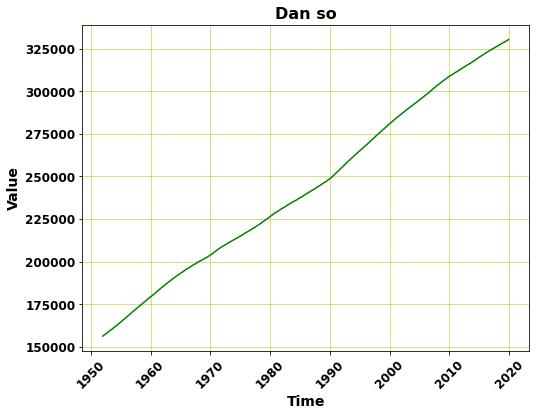

In [9]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.figure(figsize=(8, 6))
plt.plot(df_value, color='g')
plt.title('Dan so', weight='bold', fontsize=16)
plt.xlabel('Time', weight='bold', fontsize=14)
plt.ylabel('Value', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(color = 'y', linewidth = 0.5)

In [10]:
def create_regressor_attributes(df, attribute, list_of_prev_t_instants) :
    
    """
    Ensure that the index is of datetime type
    Creates features with previous time instant values
    """
        
    list_of_prev_t_instants.sort()
    start = list_of_prev_t_instants[-1] 
    end = len(df)
    df['datetime'] = df.index
    df.reset_index(drop=True)

    df_copy = df[start:end]
    df_copy.reset_index(inplace=True, drop=True)

    for attribute in attribute :
            foobar = pd.DataFrame()

            for prev_t in list_of_prev_t_instants :
                new_col = pd.DataFrame(df[attribute].iloc[(start - prev_t) : (end - prev_t)])
                new_col.reset_index(drop=True, inplace=True)
                new_col.rename(columns={attribute : '{}_(t-{})'.format(attribute, prev_t)}, inplace=True)
                foobar = pd.concat([foobar, new_col], sort=False, axis=1)

            df_copy = pd.concat([df_copy, foobar], sort=False, axis=1)
            
    df_copy.set_index(['datetime'], drop=True, inplace=True)
    return df_copy

In [11]:
list_of_attributes = ['value']

list_of_prev_t_instants = []
for i in range(1,5):
    list_of_prev_t_instants.append(i)

list_of_prev_t_instants

[1, 2, 3, 4]

In [12]:
df_new = create_regressor_attributes(df_value, list_of_attributes, list_of_prev_t_instants)
df_new.head()

,value,value_(t-1),value_(t-2),value_(t-3),value_(t-4)
datetime,,,,,
1952-05-01,157140.0,156943.0,156731.0,156527.0,156309.0
1952-06-01,157343.0,157140.0,156943.0,156731.0,156527.0
1952-07-01,157553.0,157343.0,157140.0,156943.0,156731.0
1952-08-01,157798.0,157553.0,157343.0,157140.0,156943.0
1952-09-01,158053.0,157798.0,157553.0,157343.0,157140.0


In [13]:
df_new.shape

(812, 5)

In [14]:
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

===============================================================================

In [15]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [16]:
test_set_size = 0.05
valid_set_size= 0.05

df_copy = df_new.reset_index(drop=True)

df_test = df_copy.iloc[ int(np.floor(len(df_copy)*(1-test_set_size))) : ]
df_train_plus_valid = df_copy.iloc[ : int(np.floor(len(df_copy)*(1-test_set_size))) ]

df_train = df_train_plus_valid.iloc[ : int(np.floor(len(df_train_plus_valid)*(1-valid_set_size))) ]
df_valid = df_train_plus_valid.iloc[ int(np.floor(len(df_train_plus_valid)*(1-valid_set_size))) : ]


X_train, y_train = df_train.iloc[:, 1:], df_train.iloc[:, 0]
X_valid, y_valid = df_valid.iloc[:, 1:], df_valid.iloc[:, 0]
X_test, y_test = df_test.iloc[:, 1:], df_test.iloc[:, 0]

print('Shape of training inputs, training target:', X_train.shape, y_train.shape)
print('Shape of validation inputs, validation target:', X_valid.shape, y_valid.shape)
print('Shape of test inputs, test target:', X_test.shape, y_test.shape)

Shape of training inputs, training target: (732, 4) (732,)
Shape of validation inputs, validation target: (39, 4) (39,)
Shape of test inputs, test target: (41, 4) (41,)


In [17]:
from sklearn.preprocessing import MinMaxScaler

Target_scaler = MinMaxScaler(feature_range=(0.01, 0.99))
Feature_scaler = MinMaxScaler(feature_range=(0.01, 0.99))

X_train_scaled = Feature_scaler.fit_transform(np.array(X_train))
X_valid_scaled = Feature_scaler.fit_transform(np.array(X_valid))
X_test_scaled = Feature_scaler.fit_transform(np.array(X_test))

y_train_scaled = Target_scaler.fit_transform(np.array(y_train).reshape(-1,1))
y_valid_scaled = Target_scaler.fit_transform(np.array(y_valid).reshape(-1,1))
y_test_scaled = Target_scaler.fit_transform(np.array(y_test).reshape(-1,1))

**MLPS Models**

Model 1: 
Dense1 = 60
Dense1 = 60
batch_size =5
epochs=500

In [18]:
input_layer = Input(shape=(4), dtype='float32')
dense1 = Dense(60, activation='sigmoid')(input_layer)
dense2 = Dense(60, activation='sigmoid')(dense1)
dropout_layer = Dropout(0.2)(dense2)
output_layer = Dense(1, activation='sigmoid')(dropout_layer)


model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 60)                300       
_________________________________________________________________
dense_1 (Dense)              (None, 60)                3660      
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 61        
Total params: 4,021
Trainable params: 4,021
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.fit(x=X_train_scaled, y=y_train_scaled, batch_size=5, epochs=500, verbose=1,callbacks=[callback], validation_data=(X_valid_scaled, y_valid_scaled), shuffle=True)

Epoch 1/500
147/147 [==============================] - 1s 4ms/step - loss: 0.0862 - val_loss: 0.0684
Epoch 2/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0662 - val_loss: 0.0353
Epoch 3/500
147/147 [==============================] - 0s 1ms/step - loss: 0.0352 - val_loss: 0.0096
Epoch 4/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0123 - val_loss: 0.0030
Epoch 5/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0073 - val_loss: 0.0020
Epoch 6/500
147/147 [==============================] - 0s 1ms/step - loss: 0.0049 - val_loss: 0.0016
Epoch 7/500
147/147 [==============================] - 0s 2ms/step - loss: 0.0045 - val_loss: 0.0018
Epoch 8/500
147/147 [==============================] - 0s 1ms/step - loss: 0.0040 - val_loss: 0.0016
Epoch 9/500
147/147 [==============================] - 0s 1ms/step - loss: 0.0038 - val_loss: 0.0015
Epoch 10/500
147/147 [==============================] - 0s 1ms/step - loss: 0.0031 - val_lo

In [20]:
y_pred = model.predict(X_test_scaled)

In [21]:
y_pred_rescaled = Target_scaler.inverse_transform(y_pred)

In [22]:
from sklearn.metrics import r2_score
y_test_rescaled =  Target_scaler.inverse_transform(y_test_scaled)
score = r2_score(y_test_rescaled, y_pred_rescaled)
print('R-squared score for the test set:', round(score,4))

R-squared score for the test set: 0.9974


In [23]:
y_test_rescaled.shape

(41, 1)

In [24]:
y_pred_rescaled.shape

(41, 1)

In [25]:
y_actual = pd.DataFrame(y_test_rescaled, columns=['Actual Value Population'])
y_hat = pd.DataFrame(y_pred_rescaled, columns=['Predicted Value Population'])

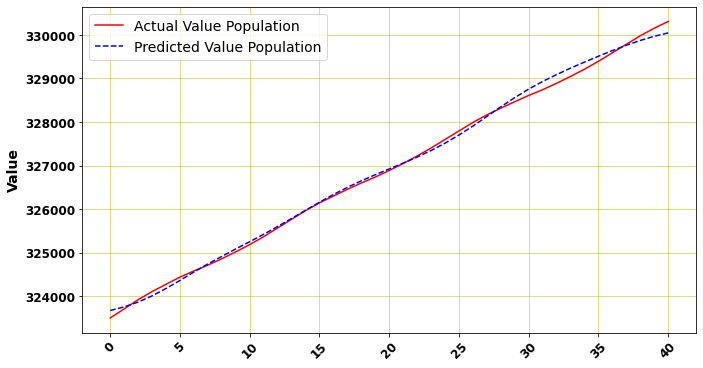

In [26]:
plt.figure(figsize=(11, 6))
plt.plot(y_actual, linestyle='solid', color='r')
plt.plot(y_hat, linestyle='dashed', color='b')

plt.legend(['Actual Value Population','Predicted Value Population'], loc='best', prop={'size': 14})

plt.ylabel('Value', weight='bold', fontsize=14)

plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(color = 'y', linewidth='0.5')
plt.show()

Model 2: Dense = 64
Dense 2 = 32
batch_size =3
epochs= 50

In [27]:
input_layer = Input(shape=(4), dtype='float32')
dense1 = Dense(64, activation='tanh')(input_layer)
dense2 = Dense(32, activation='tanh')(dense1)
dropout_layer = Dropout(0.2)(dense2)
output_layer = Dense(1, activation='tanh')(dropout_layer)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                320       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 2,433
Trainable params: 2,433
Non-trainable params: 0
_________________________________________________________________


In [28]:
model.fit(x=X_train_scaled, y=y_train_scaled, batch_size=3, epochs=50, verbose=1,callbacks=[callback], validation_data=(X_valid_scaled, y_valid_scaled), shuffle=True)

Epoch 1/50
244/244 [==============================] - 1s 2ms/step - loss: 0.1337 - val_loss: 0.0034
Epoch 2/50
244/244 [==============================] - 0s 1ms/step - loss: 0.0057 - val_loss: 0.0043
Epoch 3/50
244/244 [==============================] - 0s 1ms/step - loss: 0.0048 - val_loss: 0.0033
Epoch 4/50
244/244 [==============================] - 0s 1ms/step - loss: 0.0048 - val_loss: 0.0030
Epoch 5/50
244/244 [==============================] - 0s 1ms/step - loss: 0.0035 - val_loss: 0.0029
Epoch 6/50
244/244 [==============================] - 0s 1ms/step - loss: 0.0040 - val_loss: 0.0026
Epoch 7/50
244/244 [==============================] - 0s 1ms/step - loss: 0.0037 - val_loss: 0.0025
Epoch 8/50
244/244 [==============================] - 0s 1ms/step - loss: 0.0041 - val_loss: 0.0018
Epoch 9/50
244/244 [==============================] - 0s 1ms/step - loss: 0.0027 - val_loss: 0.0018
Epoch 10/50
244/244 [==============================] - 0s 1ms/step - loss: 0.0023 - val_loss: 0.0013

In [29]:
y_pred = model.predict(X_test_scaled)
y_pred_rescaled = Target_scaler.inverse_transform(y_pred)

In [30]:
from sklearn.metrics import r2_score
y_test_rescaled =  Target_scaler.inverse_transform(y_test_scaled)
score = r2_score(y_test_rescaled, y_pred_rescaled)
print('R-squared score for the test set:', round(score,4))

R-squared score for the test set: 0.9863


In [31]:
y_actual = pd.DataFrame(y_test_rescaled, columns=['Actual Value Population'])
y_hat = pd.DataFrame(y_pred_rescaled, columns=['Predicted Value Population'])

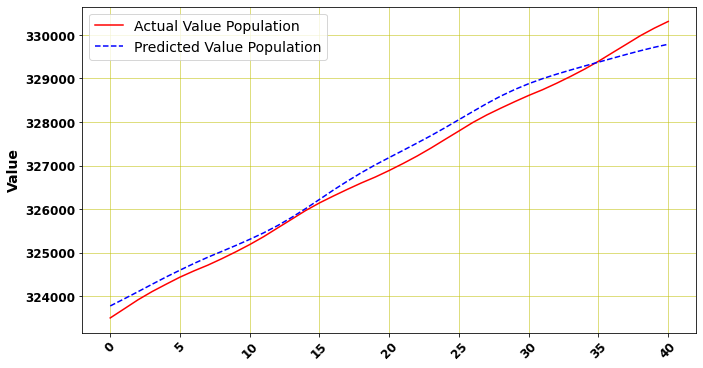

In [32]:
plt.figure(figsize=(11, 6))
plt.plot(y_actual, linestyle='solid', color='r')
plt.plot(y_hat, linestyle='dashed', color='b')

plt.legend(['Actual Value Population','Predicted Value Population'], loc='best', prop={'size': 14})
# plt.title('Bitcoin Stock Closing Prices', weight='bold', fontsize=16)
plt.ylabel('Value', weight='bold', fontsize=14)
# plt.xlabel('Test Set Day no.', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(color = 'y', linewidth='0.5')
plt.show()

**LSTM**

In [33]:
x_train=X_train_scaled
x_train

array([[0.01      , 0.01      , 0.01      , 0.01      ],
       [0.01121636, 0.0113084 , 0.01125845, 0.01134429],
       [0.01246977, 0.01252423, 0.01256624, 0.01260225],
       ...,
       [0.98831667, 0.98822631, 0.98792892, 0.9876643 ],
       [0.98912273, 0.9891943 , 0.98903246, 0.98889688],
       [0.99      , 0.99      , 0.99      , 0.99      ]])

In [34]:
x_train=np.reshape(x_train,(x_train.shape[0],1,x_train.shape[1]))
x_train.shape


(732, 1, 4)

In [35]:
y_train=y_train_scaled
y_train.shape

(732, 1)

In [36]:
model = keras.Sequential([
    keras.layers.LSTM(64,input_shape=(1,4),activation='relu',return_sequences=True),
    keras.layers.LSTM(64,activation='relu'),
    keras.layers.Dense(1)
])

In [37]:
model.compile(loss='mse',optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 64)             17664     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 50,753
Trainable params: 50,753
Non-trainable params: 0
_________________________________________________________________


In [38]:
history = model.fit(x_train,y_train,epochs=100,batch_size=32,callbacks=[callback],verbose=2)

Epoch 1/100
23/23 - 2s - loss: 0.2777
Epoch 2/100
23/23 - 0s - loss: 0.1669
Epoch 3/100
23/23 - 0s - loss: 0.0304
Epoch 4/100
23/23 - 0s - loss: 0.0077
Epoch 5/100
23/23 - 0s - loss: 0.0049
Epoch 6/100
23/23 - 0s - loss: 0.0037
Epoch 7/100
23/23 - 0s - loss: 0.0029
Epoch 8/100
23/23 - 0s - loss: 0.0025
Epoch 9/100
23/23 - 0s - loss: 0.0021
Epoch 10/100
23/23 - 0s - loss: 0.0020
Epoch 11/100
23/23 - 0s - loss: 0.0018
Epoch 12/100
23/23 - 0s - loss: 0.0018
Epoch 13/100
23/23 - 0s - loss: 0.0017
Epoch 14/100
23/23 - 0s - loss: 0.0016
Epoch 15/100
23/23 - 0s - loss: 0.0016
Epoch 16/100
23/23 - 0s - loss: 0.0015
Epoch 17/100
23/23 - 0s - loss: 0.0015
Epoch 18/100
23/23 - 0s - loss: 0.0014
Epoch 19/100
23/23 - 0s - loss: 0.0014
Epoch 20/100
23/23 - 0s - loss: 0.0013
Epoch 21/100
23/23 - 0s - loss: 0.0013
Epoch 22/100
23/23 - 0s - loss: 0.0012
Epoch 23/100
23/23 - 0s - loss: 0.0011
Epoch 24/100
23/23 - 0s - loss: 0.0011
Epoch 25/100
23/23 - 0s - loss: 0.0010
Epoch 26/100
23/23 - 0s - loss: 9.

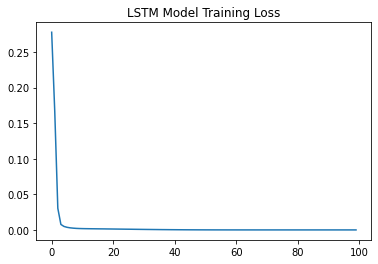

In [39]:
plt.plot(history.history['loss'])
plt.title('LSTM Model Training Loss')
plt.savefig('LSTMModel TrainingLoss.png')

In [40]:
x_test=X_test_scaled
x_test=np.reshape(x_test,(x_test.shape[0],1,x_test.shape[1]))


In [41]:
y_pred = model.predict(x_test)
y_pred_rescaled = Target_scaler.inverse_transform(y_pred)

In [42]:
y_actual = pd.DataFrame(y_test_rescaled, columns=['Actual Value Population'])
y_hat = pd.DataFrame(y_pred_rescaled, columns=['Predicted Value Population'])

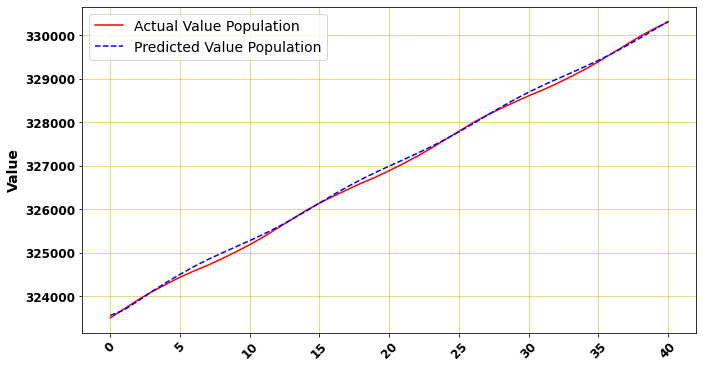

In [43]:
plt.figure(figsize=(11, 6))
plt.plot(y_actual, linestyle='solid', color='r')
plt.plot(y_hat, linestyle='dashed', color='b')

plt.legend(['Actual Value Population','Predicted Value Population'], loc='best', prop={'size': 14})
# plt.title('Bitcoin Stock Closing Prices', weight='bold', fontsize=16)
plt.ylabel('Value', weight='bold', fontsize=14)
# plt.xlabel('Test Set Day no.', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(color = 'y', linewidth='0.5')
plt.show()

In [44]:
model = keras.Sequential([
    keras.layers.LSTM(48,input_shape=(1,4),activation='relu',return_sequences=True),
    keras.layers.LSTM(48,activation='relu'),
    keras.layers.Dense(2)
])

In [45]:
model.compile(loss='mse',optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 1, 48)             10176     
_________________________________________________________________
lstm_3 (LSTM)                (None, 48)                18624     
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 98        
Total params: 28,898
Trainable params: 28,898
Non-trainable params: 0
_________________________________________________________________


In [46]:
history = model.fit(x_train,y_train,epochs=100,batch_size=32,callbacks=[callback],verbose=2)

Epoch 1/100
23/23 - 2s - loss: 0.3027
Epoch 2/100
23/23 - 0s - loss: 0.2476
Epoch 3/100
23/23 - 0s - loss: 0.1521
Epoch 4/100
23/23 - 0s - loss: 0.0370
Epoch 5/100
23/23 - 0s - loss: 0.0073
Epoch 6/100
23/23 - 0s - loss: 0.0052
Epoch 7/100
23/23 - 0s - loss: 0.0044
Epoch 8/100
23/23 - 0s - loss: 0.0039
Epoch 9/100
23/23 - 0s - loss: 0.0035
Epoch 10/100
23/23 - 0s - loss: 0.0032
Epoch 11/100
23/23 - 0s - loss: 0.0031
Epoch 12/100
23/23 - 0s - loss: 0.0029
Epoch 13/100
23/23 - 0s - loss: 0.0028
Epoch 14/100
23/23 - 0s - loss: 0.0028
Epoch 15/100
23/23 - 0s - loss: 0.0027
Epoch 16/100
23/23 - 0s - loss: 0.0026
Epoch 17/100
23/23 - 0s - loss: 0.0026
Epoch 18/100
23/23 - 0s - loss: 0.0025
Epoch 19/100
23/23 - 0s - loss: 0.0025
Epoch 20/100
23/23 - 0s - loss: 0.0024
Epoch 21/100
23/23 - 0s - loss: 0.0024
Epoch 22/100
23/23 - 0s - loss: 0.0023
Epoch 23/100
23/23 - 0s - loss: 0.0022
Epoch 24/100
23/23 - 0s - loss: 0.0022
Epoch 25/100
23/23 - 0s - loss: 0.0021
Epoch 26/100
23/23 - 0s - loss: 0.

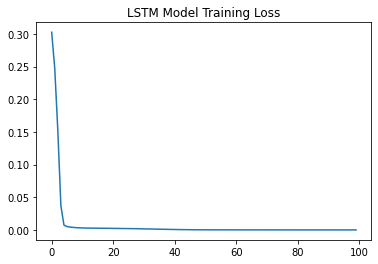

In [47]:
plt.plot(history.history['loss'])
plt.title('LSTM Model Training Loss')
plt.savefig('LSTMModel TrainingLoss.png')

In [48]:
y_pred = model.predict(x_test)
y_pred_rescaled = Target_scaler.inverse_transform(y_pred)
y_actual2 = pd.DataFrame(y_test_rescaled, columns=['Actual Value Population'])
#y_hat = pd.DataFrame(y_pred_rescaled, columns=['Predicted Value Population'])

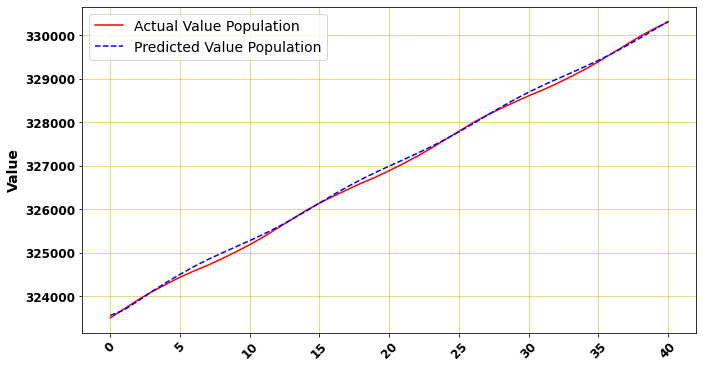

In [49]:
plt.figure(figsize=(11, 6))
plt.plot(y_actual2, linestyle='solid', color='r')
plt.plot(y_hat, linestyle='dashed', color='b')

plt.legend(['Actual Value Population','Predicted Value Population'], loc='best', prop={'size': 14})
# plt.title('Bitcoin Stock Closing Prices', weight='bold', fontsize=16)
plt.ylabel('Value', weight='bold', fontsize=14)
# plt.xlabel('Test Set Day no.', weight='bold', fontsize=14)
plt.xticks(weight='bold', fontsize=12, rotation=45)
plt.yticks(weight='bold', fontsize=12)
plt.grid(color = 'y', linewidth='0.5')
plt.show()

**Dự đoán tương lại n=1,2,3,..(tháng)**

In [50]:
def reshape2(d):
  d = np.array(d)
  d = np.reshape(d,(d.shape[0],1,d.shape[1]))
  return d

In [51]:
def split_sequence(sequence, n_steps=4):
    sequence = list(sequence)
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return reshape2(X), np.array(y)

In [53]:
train_data = df_new.value.iloc[:700]
test_data = df_new.value.iloc[700:]
len(train_data)

700

In [54]:
x_train,y_train = split_sequence(train_data)
x_test,y_test = split_sequence(test_data)
x_train.shape

(696, 1, 4)

In [55]:
model = keras.Sequential([
    keras.layers.LSTM(128,input_shape=(1,4),activation='relu',return_sequences=True),
    keras.layers.LSTM(64,activation='relu'),
    keras.layers.Dense(1)
])

In [56]:
model.compile(loss='mse',optimizer='adam')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 1, 128)            68096     
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 65        
Total params: 117,569
Trainable params: 117,569
Non-trainable params: 0
_________________________________________________________________


In [57]:
history = model.fit(x_train,y_train,epochs=100,batch_size=32,callbacks=[callback],verbose=2)

Epoch 1/100
22/22 - 3s - loss: 54022320128.0000
Epoch 2/100
22/22 - 0s - loss: 48576909312.0000
Epoch 3/100
22/22 - 0s - loss: 42089287680.0000
Epoch 4/100
22/22 - 0s - loss: 32696932352.0000
Epoch 5/100
22/22 - 0s - loss: 18974244864.0000
Epoch 6/100
22/22 - 0s - loss: 5618920448.0000
Epoch 7/100
22/22 - 0s - loss: 362509440.0000
Epoch 8/100
22/22 - 0s - loss: 21737528.0000
Epoch 9/100
22/22 - 0s - loss: 1376289.7500
Epoch 10/100
22/22 - 0s - loss: 152183.3594
Epoch 11/100
22/22 - 0s - loss: 30428.5859
Epoch 12/100
22/22 - 0s - loss: 18171.3672
Epoch 13/100
22/22 - 0s - loss: 16836.2363
Epoch 14/100
22/22 - 0s - loss: 16767.3730
Epoch 15/100
22/22 - 0s - loss: 16760.9746
Epoch 16/100
22/22 - 0s - loss: 16727.4883
Epoch 17/100
22/22 - 0s - loss: 16749.8887
Epoch 18/100
22/22 - 0s - loss: 16799.9883
Epoch 19/100
22/22 - 0s - loss: 16769.7832


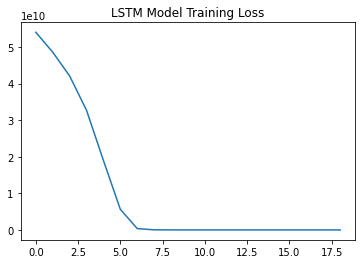

In [58]:
plt.plot(history.history['loss'])
plt.title('LSTM Model Training Loss')
plt.savefig('LSTM Model TrainingLoss.png')

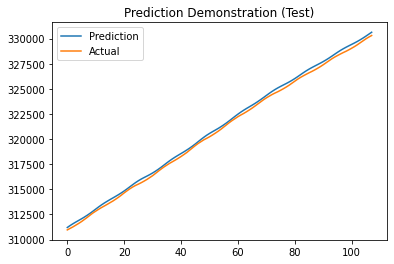

In [59]:
plt.plot(model.predict(x_test),label='Prediction')
plt.plot(y_test,label='Actual')
plt.legend()
plt.title('Prediction Demonstration (Test)')
plt.savefig('PredictionDemonstration-Test.png')

In [60]:
def predict_future(shift_count):
    def reshape(three):
        return np.array(three).reshape(1,1,4) 
    array =  list(df_new.value) + []
    now = len(df_new)-4
    last = len(df_new)
    for _ in range(shift_count):
        converted = reshape(array[now:last])
        array.append(model.predict(converted)[0][0])
        now += 1
        last += 1
    return array

In [61]:
n=36

In [62]:
future_prediction = predict_future(n)


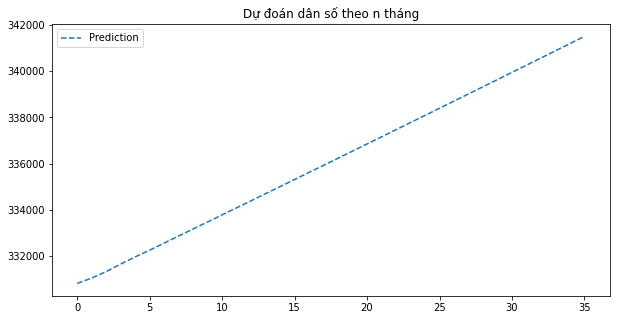

In [63]:
plt.figure(figsize=(10,5))
plt.plot(future_prediction[len(future_prediction)-n:],'--',label='Prediction')
#plt.plot(df_new.value,label='Actual Data',alpha=0.7)
plt.title('Dự đoán dân số theo n tháng')
plt.legend();
plt.savefig('Result.png')

In [65]:
future_prediction[len(future_prediction)-1]

341505.12